## General Information

This notebook is used to train a simple neural network model to predict the chemistry in the barite benchmark (50x50 grid). The training data is stored in the repository using **git large file storage** and can be downloaded after the installation of git lfs using the `git lfs pull` command.

It is then recommended to create a Python environment using miniconda. The necessary dependencies are contained in `environment.yml` and can be installed using `conda env create -f environment.yml`.

The data set is divided into a design and result part and consists of the iterations of a reference simulation. The design part of the data set contains the chemical concentrations at time $t$ and the result part at time $t+1$, which are to be learned by the model.

## Setup Libraries

In [47]:
import keras
print("Running Keras in version {}".format(keras.__version__))

import h5py
import numpy as np
import pandas as pd
import time
import sklearn.model_selection as sk
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE
from collections import Counter

Running Keras in version 3.6.0


## Define parameters

In [116]:
dtype = "float32"
activation = "relu"

lr = 0.001
batch_size = 512
epochs = 50 # default 400 epochs

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=lr,
    decay_steps=2000,
    decay_rate=0.9,
    staircase=True
)

optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
loss = keras.losses.Huber()

sample_fraction = 0.8

## Setup the model

In [4]:
model_simple = keras.Sequential(
    [
        keras.Input(shape = (12,), dtype = "float32"),
        keras.layers.Dense(units = 128, activation = "relu", dtype = "float32"),
        keras.layers.Dense(units = 128, activation = "relu", dtype = "float32"),
        keras.layers.Dense(units = 12, dtype = "float32")
    ]
)

model_simple.compile(optimizer=optimizer, loss = loss)
model_simple.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,724 (77.05 KB)

 Trainable params: 19,724 (77.05 KB)

 Non-trainable params: 0 (0.00 B)

In [117]:
model_large =   keras.Sequential(
    [keras.layers.Input(shape=(12,), dtype=dtype),
     keras.layers.Dense(512, activation='relu', dtype=dtype),
     keras.layers.Dense(1024, activation='relu', dtype=dtype),
     keras.layers.Dense(512, activation='relu', dtype=dtype),
     keras.layers.Dense(12, dtype=dtype)
     ])

model_large.compile(optimizer=optimizer, loss = loss)
model_large.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 512)            │         6,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 12)             │         6,156 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,062,924 (4.05 MB)

 Trainable params: 1,062,924 (4.05 MB)

 Non-trainable params: 0 (0.00 B)

## Define some functions and helper classes

In [5]:
def Safelog(val):
    # get range of vector
    if val > 0:
        return np.log10(val)
    elif val < 0:
        return -np.log10(-val)
    else:
        return 0

def Safeexp(val):
    if val > 0:
        return -10 ** -val
    elif val < 0:
        return 10 ** val
    else:
        return 0


In [6]:
# ? Why does the charge is using another logarithm than the other species

func_dict_in = {
    "H" : np.log1p,
    "O" : np.log1p,
    "Charge" : Safelog,
    "H_0_" : np.log1p,
    "O_0_" : np.log1p,
    "Ba" : np.log1p,
    "Cl" : np.log1p,
    "S_2_" : np.log1p,
    "S_6_" : np.log1p,
    "Sr" : np.log1p,
    "Barite" : np.log1p,
    "Celestite" : np.log1p,
}

func_dict_out = {
    "H" : np.expm1,
    "O" : np.expm1,
    "Charge" : Safeexp,
    "H_0_" : np.expm1,
    "O_0_" : np.expm1,
    "Ba" : np.expm1,
    "Cl" : np.expm1,
    "S_2_" : np.expm1,
    "S_6_" : np.expm1,
    "Sr" : np.expm1,
    "Barite" : np.expm1,
    "Celestite" : np.expm1,
}


## Read data from `.h5` file and convert it to a `pandas.DataFrame`

In [86]:
data_file = h5py.File("Barite_50_Data_training.h5")

design = data_file["design"]
results = data_file["result"]

df_design = pd.DataFrame(np.array(design["data"]).transpose(), columns = design["names"].asstr())
df_results = pd.DataFrame(np.array(results["data"]).transpose(), columns = results["names"].asstr())

data_file.close()

## Classify each cell with kmeans

In [87]:
# widget with slider for the index

class_label_design = np.array([])
class_label_result = np.array([])


i = 1000
for i in range(0,1001):
    field_design = np.array(df_design['Barite'][(i*2500):(i*2500+2500)]).reshape(50,50)
    field_result = np.array(df_results['Barite'][(i*2500):(i*2500+2500)]).reshape(50,50)
    
    kmeans_design = KMeans(n_clusters=2, random_state=0).fit(field_design.reshape(-1,1))
    kmeans_result = KMeans(n_clusters=2, random_state=0).fit(field_result.reshape(-1,1))
    
    class_label_design = np.append(class_label_design.astype(int), kmeans_design.labels_)
    class_label_result = np.append(class_label_result.astype(int), kmeans_result.labels_)
    


class_label_design = pd.DataFrame(class_label_design, columns = ["Class"])
class_label_result = pd.DataFrame(class_label_result, columns = ["Class"])


/home/signer/bin/miniconda3/envs/training/lib/python3.11/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


In [88]:
if("Class" in df_design.columns and "Class" in df_results.columns):
    print("Class column already exists")
else:
    df_design = pd.concat([df_design, class_label_design], axis=1)
    df_results = pd.concat([df_results, class_label_design], axis=1)

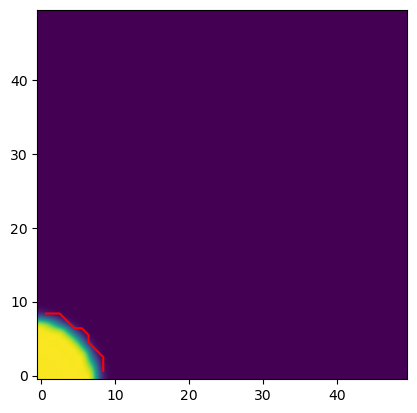

In [89]:
i=1000

plt.imshow(np.array(df_results['Barite'][(i*2500):(i*2500+2500)]).reshape(50,50), interpolation='bicubic', origin='lower')
plt.contour(np.array(df_results['Class'][(i*2500):(i*2500+2500)]).reshape(50,50), levels=[0.1], colors='red', origin='lower')

## Split into Training and Testing datsets

In [90]:
X_train, X_test, y_train, y_test = sk.train_test_split(df_design, df_results, test_size = 0.2)

## Perform SMOT Sampling on dataset to balance classes

In [91]:
Counter(df_design['Class'])
oversample = SMOTE()

design_resampled, design_classes_resampled = oversample.fit_resample(X_train.iloc[:, :-1], X_train.iloc[:, -1])
target_resampled, target_classes_resampled = oversample.fit_resample(y_train.iloc[:, :-1], y_train.iloc[:, -1])


In [94]:
X_train = pd.concat([design_resampled, design_classes_resampled], axis=1)
y_train = pd.concat([target_resampled, target_classes_resampled], axis=1)

## Define Scaling and Normalization Functions

In [96]:
def log_scale(df_design, df_result, func_dict):
    
    df_design = df_design.copy()
    df_result = df_result.copy()
    
    for key in df_design.keys():
        if key != "Class":
            df_design[key] = np.vectorize(func_dict[key])(df_design[key])
            df_result[key] = np.vectorize(func_dict[key])(df_result[key])
        
    return df_design, df_result

# Get minimum and maximum values for each column
def get_min_max(df_design, df_result):
    
    min_vals_des = df_design.min()
    max_vals_des = df_design.max()
    
    min_vals_res = df_result.min()
    max_vals_res = df_result.max()

    # minimum of input and output data to get global minimum/maximum
    data_min = np.minimum(min_vals_des, min_vals_res).to_dict()
    data_max = np.maximum(max_vals_des, max_vals_res).to_dict()

    return data_min, data_max


In [ ]:
df_design_log, df_results_log = log_scale(df_design, df_results, func_dict_in)
data_min_log, data_max_log = get_min_max(df_design_log, df_results_log)

In [101]:
X_train_log, y_train_log = log_scale(X_train, y_train, func_dict_in)
X_test_log, y_test_log = log_scale(X_test, y_test, func_dict_in)

In [102]:
train_min_log, train_max_log = get_min_max(X_train_log, y_train_log)
test_min_log, test_max_log = get_min_max(X_test_log, y_test_log)

In [100]:
def preprocess(data, func_dict, data_min, data_max):
    data = data.copy()
    for key in data.keys():
        if key != "Class":
            data[key] = (data[key] - data_min[key]) / (data_max[key] - data_min[key])

    return data

def postprocess(data, func_dict, data_min, data_max):
    data = data.copy()
    for key in data.keys():
        if key != "Class":
            data[key] = data[key] * (data_max[key] - data_min[key]) + data_min[key]
            data[key] = np.vectorize(func_dict[key])(data[key])
    return data

## Preprocess the data

In [13]:
pp_design = preprocess(df_design_log, func_dict_in, data_min_log, data_max_log)
pp_results = preprocess(df_results_log, func_dict_in, data_min_log, data_max_log)

In [103]:
X_train_preprocess = preprocess(X_train_log, func_dict_in, train_min_log, train_max_log)
y_train_preprocess = preprocess(y_train_log, func_dict_in, train_min_log, train_max_log)

X_test_preprocess = preprocess(X_test_log, func_dict_in, test_min_log, test_max_log)
y_test_preprocess = preprocess(y_test_log, func_dict_in, test_min_log, test_max_log)

## Sample the data

In [105]:
X_train, X_val, y_train, y_val = sk.train_test_split(X_train_preprocess, y_train_preprocess, test_size = 0.1)


## Custom Loss function

In [ ]:
def custom_loss_H20(df_design_log, df_result_log, data_min_log, data_max_log, func_dict_out, postprocess):
    df_result = postprocess(df_result_log, func_dict_out, data_min_log, data_max_log)    
    return keras.losses.Huber + np.sum(((df_result['H'] / df_result['O']) - 2)**2)

def loss_wrapper(data_min_log, data_max_log, func_dict_out, postprocess):
    def loss(df_design_log, df_result_log):
        return custom_loss_H20(df_design_log, df_result_log, data_min_log, data_max_log, func_dict_out, postprocess)
    return loss

In [106]:
X_train.iloc[:, :-1].shape

(3559968, 12)

## Train the model

In [ ]:
# measure time
start = time.time()

history = model_large.fit(X_train.iloc[:, :-1], 
            y_train.iloc[:, :-1], 
            batch_size = batch_size, 
            epochs = epochs, 
            validation_data = (X_val.iloc[:,:-1], y_val.iloc[:, :-1])
)

end = time.time()

print("Training took {} seconds".format(end - start))

Epoch 1/50
6954/6954 ━━━━━━━━━━━━━━━━━━━━ 91s 13ms/step - loss: 0.0070 - val_loss: 0.0066
Epoch 2/50
6954/6954 ━━━━━━━━━━━━━━━━━━━━ 104s 15ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 3/50
1147/6954 ━━━━━━━━━━━━━━━━━━━━ 2:01 21ms/step - loss: 0.0066

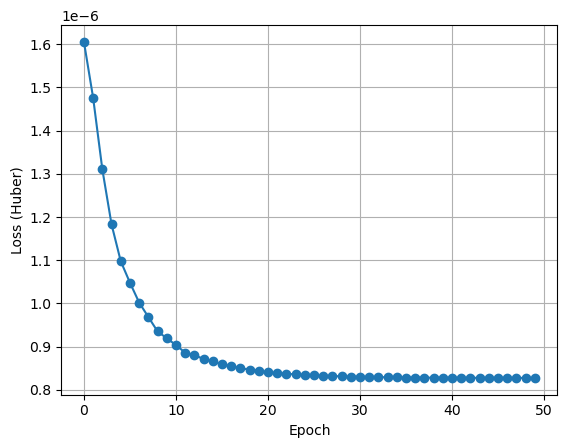

In [26]:
plt.plot(history.history["loss"], "o-", label = "Training Loss")
plt.xlabel("Epoch")
# plt.yscale('log')
plt.ylabel("Loss (Huber)")
plt.grid('on')

plt.savefig("loss_all.png", dpi=300)


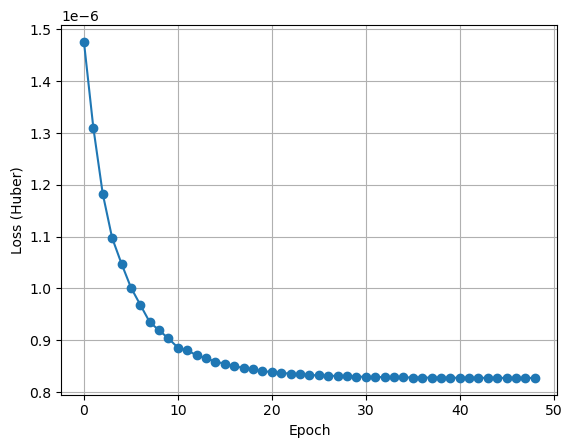

In [27]:
plt.plot(history.history["loss"][1:], "o-", label = "Training Loss")
plt.xlabel("Epoch")
# plt.yscale('log')
plt.ylabel("Loss (Huber)")
plt.grid('on')
plt.savefig("loss_1_to_end.png", dpi=300)


In [42]:
df_design

H          O        Charge           H_0_          O_0_  \
0        111.012434  55.508192 -7.779554e-09   2.697041e-26  2.210590e-15   
1        111.012434  55.508427 -4.736083e-09   1.446346e-26  2.473481e-15   
2        111.012434  55.508691 -1.311169e-09   3.889826e-28  2.769320e-15   
3        111.012434  55.508698 -1.220023e-09   1.442658e-29  2.777193e-15   
4        111.012434  55.508699 -1.216643e-09   5.350528e-31  2.777485e-15   
...             ...        ...           ...            ...           ...   
2502495  111.012434  55.507488  3.573728e-09  5.424062e-145  1.375204e-10   
2502496  111.012434  55.507501  3.494007e-09  2.011675e-146  1.377139e-10   
2502497  111.012434  55.507512  3.429764e-09  7.460897e-148  1.377819e-10   
2502498  111.012434  55.507520  3.381745e-09  2.767237e-149  1.371144e-10   
2502499  111.012434  55.507525  3.348864e-09  5.321610e-151  1.376026e-10   

                   Ba            Cl           S_2_      S_6_        Sr  \
0        2.041069e-02  4.082138e-02   0.000000e+00  0.000494  0.000494   
1        1.094567e-02  2.189133e-02   0.000000e+00  0.000553  0.000553   
2        2.943745e-04  5.887491e-04   0.000000e+00  0.000619  0.000619   
3        1.091776e-05  2.183551e-05   0.000000e+00  0.000620  0.000620   
4        4.049176e-07  8.098352e-07   0.000000e+00  0.000620  0.000620   
...               ...           ...            ...       ...       ...   
2502495  9.953520e-07  2.266555e-03  5.509534e-149  0.000318  0.001450   
2502496  9.817216e-07  2.217997e-03  2.043375e-150  0.000321  0.001429   
2502497  9.706451e-07  2.179066e-03  7.578467e-152  0.000324  0.001412   
2502498  9.621074e-07  2.149820e-03  2.810844e-153  0.000326  0.001400   
2502499  9.564401e-07  2.129912e-03  5.405468e-155  0.000327  0.001391   

         Barite  Celestite  Class  
0         0.001   1.000000      0  
1         0.001   1.000000      0  
2         0.001   1.000000      0  
3         0.001   1.000000      0  
4         0.001   1.000000      0  
...         ...        ...    ...  
2502495   0.001   1.000014      0  
2502496   0.001   1.000010      0  
2502497   0.001   1.000006      0  
2502498   0.001   1.000004      0  
2502499   0.001   1.000001      0  

[2502500 rows x 13 columns]

## Test the model

In [29]:
# test on all test data
model.evaluate(X_test.iloc[:,:-1], y_test)

15641/15641 ━━━━━━━━━━━━━━━━━━━━ 5s 336us/step - loss: 6.6414e-07


8.585521982240607e-07

In [36]:
# test on non-reactive data
model.evaluate(X_test[X_test['Class'] == 0].iloc[:,:-1], y_test[X_test['Class'] == 0])

15454/15454 ━━━━━━━━━━━━━━━━━━━━ 5s 331us/step - loss: 2.7927e-07


3.939527175589319e-07

In [37]:
# test on reactive data
model.evaluate(X_test[X_test['Class'] == 1].iloc[:,:-1], y_test[X_test['Class'] == 1])

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 3.3173e-05


3.921399184037e-05

## Save the model

In [53]:
# Save the model
model.save("Barite_50_Model_additional_species.keras")